In [5]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
import sys
sys.path.append("/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [7]:
USE_CUDA = False

In [8]:
Timeseries = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Time series/flocks_timeseries_2dim_hf4.csv',encoding='utf-8',header=None)

In [9]:
Adj = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/hf4_matrix.csv',encoding='utf-8',header=None)

In [10]:
model = 'flocks'

In [11]:
Num_nodes = Adj.shape[0]
Dimension = int(Timeseries.shape[1]/Num_nodes)

In [12]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [13]:
delt_t = 0.01

In [14]:
timeseries_t0 = timeseries[0:-1,:,:]
timeseries_t1 = timeseries[1:,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [15]:
timeseries_t2 = timeseries[2:,:,:]
dVdt = (timeseries_t2-2*timeseries_t1[:-1,:,:]+timeseries[0:-2,:,:])/delt_t**2

In [16]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [17]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [18]:
#data = data.reshape((10,-1,4,6))
import numpy as np
goal_data = np.concatenate([timeseries[3:,:,:],dXdt[1:-1,:,:],dVdt[:-1,:,:]],axis=2)
#goal_data = data[1:-1,:,0:Dimension]
mapping_data = np.concatenate((timeseries[1:-2,:,:],dXdt[0:-2,:,:]),axis=2)

In [19]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [22]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [23]:
aggr = 'add'
hidden = 100


msg_dim = 3
n_f = mapping_data.shape[2]

In [24]:
dim = Dimension*1

In [25]:
from torch_geometric.data import Data, DataLoader

In [27]:
ogn = SDI_Difftype(model,n_f, msg_dim, dim, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [28]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []

In [29]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [30]:
ogn.loss(_q)

tensor(1043.7849, grad_fn=<AddBackward0>)

In [31]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [32]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [33]:
init_lr = 1e-4

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 30

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

In [34]:
epoch = 0
from tqdm import tqdm

In [35]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

In [36]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source

        s2 = tmp.x[tmp.edge_index[1]] #target

        #Tmp = torch.cat([s2, s1],dim=1) # tmp --> xi,xj
        xtmp = (s1[:,0:dim]-s2[:,0:dim])
        vtmp = (s1[:,dim:dim*2]-s2[:,dim:dim*2])
        if dim == 1:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2)
        if dim == 2:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2)
        if dim == 3:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2+(s1[:,2]-s2[:,2])**2)
 
        cohesion = ogn.msg_fnc_cohesion(Xtmp.reshape(-1,1))
        align = ogn.msg_fnc_align(Xtmp.reshape(-1,1))
        #repulsion = ogn.msg_fnc_repulsion(Xtmp.reshape(-1,1))
    
        all_messages = torch.cat((
            xtmp,vtmp,cohesion,align), dim=1)
        if dim == 1:
            columns = ['xij','dxij','c1','a1']
        if dim == 2:
            columns = ['xij','yij','dxij','dyij','c1','a1']
        elif dim == 3:
            columns = ['xij','yij','zij','dxij','dyij','dzij','c1','a1']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [37]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['xi','dxi','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['xi','yi','dxi','dyi','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['xi','yi','zi','dxi','dyi','dzi','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [38]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            vtmp = torch.sqrt(tmp[:,1]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,1:2],self_dyn), dim=1)
            columns = ['dxi','s1']
            
        if dim==2:
            vtmp = tmp[:,2]**2+tmp[:,3]**2
            vxtmp = torch.cat((vtmp.reshape(-1,1),tmp[:,2].reshape(-1,1)),dim=1)
            vytmp = torch.cat((vtmp.reshape(-1,1),tmp[:,3].reshape(-1,1)),dim=1)
            
            self_dyn_x = ogn.node_fnc_strength_x(vxtmp)#vtmp.reshape(-1,1)
            self_dyn_y = ogn.node_fnc_strength_y(vytmp)#vtmp.reshape(-1,1)
            self_dyn_all = torch.cat((vtmp.reshape(-1,1),tmp[:,2:4],self_dyn_x, self_dyn_y), dim=1)
            columns = ['Vi','dxi','dyi','s1','s2']
        if dim==3:
            vtmp = torch.sqrt(tmp[:,3]**2+tmp[:,4]**2+tmp[:,5]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,3:6],self_dyn), dim=1)
            columns = ['dxi','dyi','dzi','s1']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info

In [39]:
recorded_models = []

In [40]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            #if test in ['_l1_', '_kl_']:
                #loss, reg = new_loss(ogn, ginput, square=False)
                #((loss + reg)/int(ginput.batch[-1]+1)).backward()
            #else:
            #loss = ogn.loss(ginput, square=False)
            loss = ogn.loss(ginput)
            loss.backward()
            #(loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(copy(ogn.state_dict()))

  0%|                                                    | 0/30 [00:00<?, ?it/s]

173.22496963110203
7.528431901598293


  3%|█▍                                         | 1/30 [01:54<55:23, 114.59s/it]

5.655070521998818
2.8379785882782738


  7%|██▊                                        | 2/30 [03:48<53:22, 114.38s/it]

-3.619074027801337
-13.270175880530616


 10%|████▎                                      | 3/30 [05:43<51:32, 114.53s/it]

-33.00082287166779
-59.8160195384711


 13%|█████▋                                     | 4/30 [07:37<49:36, 114.47s/it]

-101.79121214780315
-143.39263281874196


 17%|███████▏                                   | 5/30 [09:32<47:41, 114.47s/it]

-144.63220653731528
-152.6137524652726


 20%|████████▌                                  | 6/30 [11:26<45:46, 114.45s/it]

-146.41144291915253
-153.5805462957818


 23%|██████████                                 | 7/30 [13:22<44:03, 114.92s/it]

-146.81428100483893
-151.14324842931813


 27%|███████████▍                               | 8/30 [15:18<42:15, 115.24s/it]

-148.96841660693903
-154.46400551677033


 30%|████████████▉                              | 9/30 [17:14<40:25, 115.51s/it]

-150.87846995569038
-158.05511809656355


 33%|██████████████                            | 10/30 [19:10<38:32, 115.63s/it]

-152.5560599697104
-150.64334710371315


 37%|███████████████▍                          | 11/30 [21:07<36:42, 115.95s/it]

-153.81273316962267
-157.5597344855196


 40%|████████████████▊                         | 12/30 [23:03<34:50, 116.16s/it]

-158.12090349207074
-164.36477800735722


 43%|██████████████████▏                       | 13/30 [24:59<32:53, 116.11s/it]

-160.4472916783589
-159.6790265242159


 47%|███████████████████▌                      | 14/30 [26:55<30:57, 116.07s/it]

-162.39765916251918
-157.85135622427327


 50%|█████████████████████                     | 15/30 [28:51<29:00, 116.01s/it]

-165.98139792797437
-171.60250216908497


 53%|██████████████████████▍                   | 16/30 [30:47<27:04, 116.02s/it]

-169.40060744910474
-140.2529119521936


 57%|███████████████████████▊                  | 17/30 [32:43<25:08, 116.05s/it]

-173.1839828170533
-179.87673983470526


 60%|█████████████████████████▏                | 18/30 [34:39<23:12, 116.04s/it]

-176.90051732451997
-178.03444561000336


 63%|██████████████████████████▌               | 19/30 [36:36<21:16, 116.08s/it]

-180.6318652691656
-186.52144233731343


 67%|████████████████████████████              | 20/30 [38:36<19:34, 117.41s/it]

-184.36422476144648
-184.68548948099357


 70%|█████████████████████████████▍            | 21/30 [40:34<17:37, 117.49s/it]

-188.24086026978938
-193.01412134281688


 73%|██████████████████████████████▊           | 22/30 [42:33<15:44, 118.05s/it]

-192.06248277255796
-188.7104057276633


 77%|████████████████████████████████▏         | 23/30 [44:33<13:49, 118.45s/it]

-195.0310150338653
-195.17776030671823


 80%|█████████████████████████████████▌        | 24/30 [46:32<11:52, 118.70s/it]

-197.30427575803188
-199.3105997213939


 83%|███████████████████████████████████       | 25/30 [48:33<09:56, 119.33s/it]

-199.2631274557879
-199.6196478234002


 87%|████████████████████████████████████▍     | 26/30 [50:31<07:56, 119.03s/it]

-200.60741687003897
-201.51909734503877


 90%|█████████████████████████████████████▊    | 27/30 [52:30<05:57, 119.00s/it]

-201.34985522845085
-200.76229849984017


 93%|███████████████████████████████████████▏  | 28/30 [54:29<03:58, 119.03s/it]

-201.82354744434483
-201.84390788515165


 97%|████████████████████████████████████████▌ | 29/30 [56:27<01:58, 118.78s/it]

-202.08244740182707
-201.98866865763108


100%|██████████████████████████████████████████| 30/30 [58:25<00:00, 116.87s/it]


In [41]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [52]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
vx_Update = []
vy_Update = []
vz_Update = []
for i in range(0,50000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp,v_tmp= ogn.sample_trajectories(_q)
    if i < X.shape[0]-2:
        X[i+2,:,0:dim] = x_tmp
        
        X[i+1,:,dim:] = v_tmp
    else:
        break
    x_Update.append(x_tmp[:,0].reshape(1,-1))
    y_Update.append(x_tmp[:,1].reshape(1,-1))
    #z_Update.append(x_tmp[:,2].reshape(1,-1))
    vx_Update.append(v_tmp[:,0].reshape(1,-1))
    vy_Update.append(v_tmp[:,1].reshape(1,-1))
    #vz_Update.append(v_tmp[:,2].reshape(1,-1))
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
#z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)
vx_i = torch.stack(vx_Update, dim=0).reshape(-1,Num_nodes)
vy_i = torch.stack(vy_Update, dim=0).reshape(-1,Num_nodes)
#vz_i = torch.stack(vz_Update, dim=0).reshape(-1,Num_nodes)

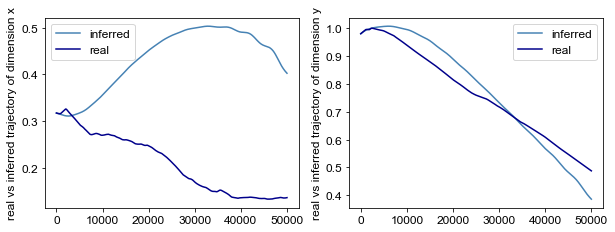

In [53]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/pigeonflocks_trajectories/hf1/flocks_timeseries_2dim_hf4.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
#plt.rcParams['savefig.dpi'] = 300 
#plt.rcParams['figure.dpi'] = 300
Nindex =0
TIME = 50000
x_tra = x_i.detach().numpy()[0:TIME,Nindex-1]
x_real = time1.iloc[0:,Nindex*2-2]
fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(1,2,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[2:x_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
y_tra = y_i.detach().numpy()[0:TIME,Nindex-1]
y_real = time1.iloc[0:,Nindex*2-1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[2:y_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_average_trajectories.png')
plt.show()
#plt.close()

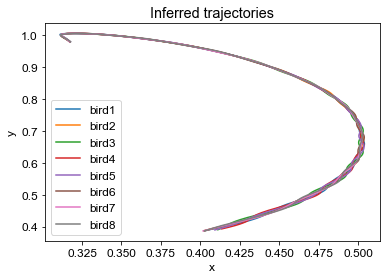

In [58]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

r = np.linspace(0, 500, 50000)
fig, ax = plt.subplots()
x1 = x_i.detach().numpy()[0:TIME,0]
y1 = y_i.detach().numpy()[0:TIME,0]
ax.plot(x1, y1, label='bird1')
#ax.scatter(x1, y1, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x2 = x_i.detach().numpy()[0:TIME,1]
y2 = y_i.detach().numpy()[0:TIME,1]
ax.plot(x2, y2, label='bird2')
#ax.scatter(x2, y2, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x3 = x_i.detach().numpy()[0:TIME,2]
y3 = y_i.detach().numpy()[0:TIME,2]
ax.plot(x3, y3, label='bird3')
#ax.scatter(x3, y3, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x4 = x_i.detach().numpy()[0:TIME,3]
y4 = y_i.detach().numpy()[0:TIME,3]
ax.plot(x4, y4, label='bird4')
#ax.scatter(x4, y4, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x5 = x_i.detach().numpy()[0:TIME,4]
y5 = y_i.detach().numpy()[0:TIME,4]
ax.plot(x5, y5, label='bird5')
#ax.scatter(x5, y5, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x6 = x_i.detach().numpy()[0:TIME,5]
y6 = y_i.detach().numpy()[0:TIME,5]
ax.plot(x6, y6, label='bird6')
#ax.scatter(x6, y6, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x7 = x_i.detach().numpy()[0:TIME,6]
y7 = y_i.detach().numpy()[0:TIME,6]
ax.plot(x7, y7, label='bird7')
#ax.scatter(x7, y7, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x8 = x_i.detach().numpy()[0:TIME,7]
y8 = y_i.detach().numpy()[0:TIME,7]
ax.plot(x8, y8, label='bird8')
#ax.scatter(x8, y8, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)

# x = x_real[1:20001,]
# y = y_real[1:20001,]
# ax.scatter(x, y, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inferred trajectories')
ax.legend()
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_tmp.pdf')
plt.show()

In [59]:
np.savetxt('hf4_inferred_traj_x_net.csv',x_i.detach().numpy(),delimiter=',')
np.savetxt('hf4_inferred_traj_y_net.csv',y_i.detach().numpy(),delimiter=',')

/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_31230/2751892123.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


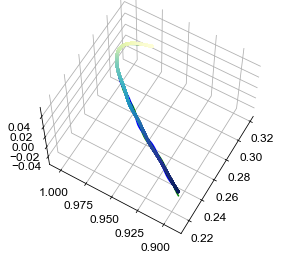

In [116]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.azim = -150
ax.dist = 9
ax.elev = 60
r = np.linspace(0, 200, 20000)


x_tra_1 = x_i.detach().numpy()[0:TIME,Nindex+1]
y_tra_1 = y_i.detach().numpy()[0:TIME,Nindex+1]
#z_tra_1 = z_i.detach().numpy()[0:TIME,Nindex+1]
x = x_tra_1#x_real[1:x_tra.shape[0]+1,]
y = y_tra_1#y_real[1:y_tra.shape[0]+1,]
#z = z_tra_1#z_real[1:z_tra.shape[0]+1,]

x_tra_2 = x_i.detach().numpy()[0:TIME,Nindex+2]
y_tra_2 = y_i.detach().numpy()[0:TIME,Nindex+2]
#z_tra_2 = z_i.detach().numpy()[0:TIME,Nindex+2]
x2 = x_tra_2#x_real[1:x_tra.shape[0]+1,]
y2 = y_tra_2 #y_real[1:y_tra.shape[0]+1,]
#z2 = z_tra_2#z_real[1:z_tra.shape[0]+1,]

x_tra_3 = x_i.detach().numpy()[0:TIME,Nindex+3]
y_tra_3 = y_i.detach().numpy()[0:TIME,Nindex+3]
#z_tra_3 = z_i.detach().numpy()[0:TIME,Nindex+3]
x3 = x_tra_3#x_real[1:x_tra.shape[0]+1,]
y3 = y_tra_3 #y_real[1:y_tra.shape[0]+1,]
#z3 = z_tra_3#z_real[1:z_tra.shape[0]+1,]


x1 = x_tra
y1 = y_tra
#z1 = z_tra

#1 colored by value of `z`
ax.plot(x, y, c = 'k') 
ax.plot(x2, y2, c = 'g') 
ax.plot(x3, y3, c = 'b') 
#2 colored by index (same in this example since z is a linspace too)

ax.scatter(x1, y1, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 3)

plt.show()

In [198]:
bestMe = messages_over_time[29]

In [199]:
bestMe

,xij,yij,dxij,dyij,c1,a1,epoch,loss
0,0.000097,0.000377,-0.000097,-0.000031,0.002771,0.001040,29,-188.117627
1,-0.000990,0.000415,0.000030,-0.000035,0.002729,0.001015,29,-188.117627
2,-0.000741,0.000507,-0.000043,-0.000035,0.002740,0.001021,29,-188.117627
3,0.000391,0.000356,-0.000165,-0.000081,0.002762,0.001035,29,-188.117627
4,0.000260,0.000254,-0.000202,-0.000078,0.002773,0.001041,29,-188.117627
...,...,...,...,...,...,...,...,...
55995,0.000522,0.000067,-0.000103,0.000076,0.002763,0.001035,29,-188.117627
55996,0.000056,0.000148,0.000040,0.000067,0.002785,0.001048,29,-188.117627
55997,0.000089,-0.000064,-0.000108,0.000032,0.002788,0.001050,29,-188.117627
55998,0.000798,0.000331,-0.000091,0.000059,0.002742,0.001022,29,-188.117627


In [200]:
rij_val = np.sqrt(bestMe['xij'].values**2+bestMe['yij'].values**2)
#cohesion_true = 1.5*(1-(rij_val/2)**3)/(1+(rij_val/2)**6) # x1 (x_i) is target, x2 (x_j) is source 
align_true = np.exp(-rij_val/3)#np.sin(bestMe['x2'].values-bestMe['x1'].values)

In [201]:
maxy = np.max(bestMe['a1'].values)
miny = np.min(bestMe['a1'].values)
maxx = np.max(align_true)
minx = np.min(align_true)
align_true = (maxy-miny)*(align_true-minx)/(maxx-minx) + miny

In [202]:
(maxy-miny)/(maxx-minx)

0.11006817

In [203]:
minx

0.9988282

In [204]:
maxx-minx

0.0011715889

In [205]:
miny

0.0009249449

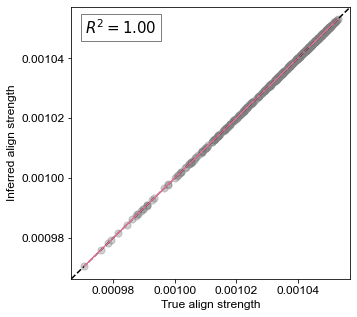

In [235]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sx = bestMe['a1'].values[0:1000]#*bestMe['dxij']*m2
sx_true = align_true[0:1000]#*bestMe['dxij']
sy = bestMe['a1'].values[0:5000]#*bestMe['dyij']*m2
sy_true = align_true[0:5000]#*bestMe['dyij']
#sz = bestMe['a1'].values#*bestMe['dzij']*m2
#sz_true = align_true#*bestMe['dzij']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1,1,1)
#plt.title("true align- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True align strength")
plt.ylabel("Inferred align strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_align.pdf')

In [250]:
coup_value = -((rij_val/2-1)**3/(1+rij_val/2)**6)+1
#coup_value = ((rij_val/0.1)**3-1)/((rij_val/0.1)**6+1)

In [251]:
maxy = np.max(bestMe['c1'].values)
miny = np.min(bestMe['c1'].values)
maxx = np.max(coup_value)
minx = np.min(coup_value)
coup_value = (maxy-miny)*(coup_value-minx)/(maxx-minx) + miny

In [252]:
coup_value

array([0.00277083, 0.00272887, 0.00273961, ..., 0.00278802, 0.00274168,
       0.00277642], dtype=float32)

In [254]:
-0.01368125*(((rij_val/2-1)**3/(1+rij_val/2)**6)-1+1.9843001)+0.0025799908

array([0.00277083, 0.00272887, 0.00273961, ..., 0.00278802, 0.00274168,
       0.00277642], dtype=float32)

In [243]:
(maxy-miny)/(maxx-minx)

0.01368125

In [253]:
minx

1.9843001

In [245]:
maxx-minx

0.015696526

In [246]:
miny

0.0025799908

Text(0, 0.5, 'inferred cohesion strength')

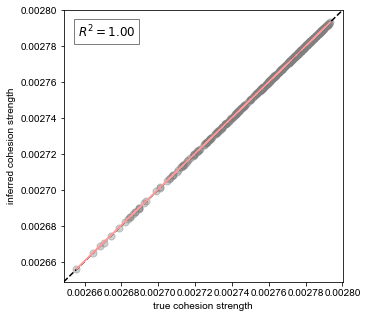

In [247]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
temp = bestMe['c1'].values[0:1000]
coup_value = coup_value[0:1000]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=50,c ='grey', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.5)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
#plt.title('Relation-rij-cohesion')
plt.xlabel("true cohesion strength")
plt.ylabel("inferred cohesion strength")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_cohesion.pdf')

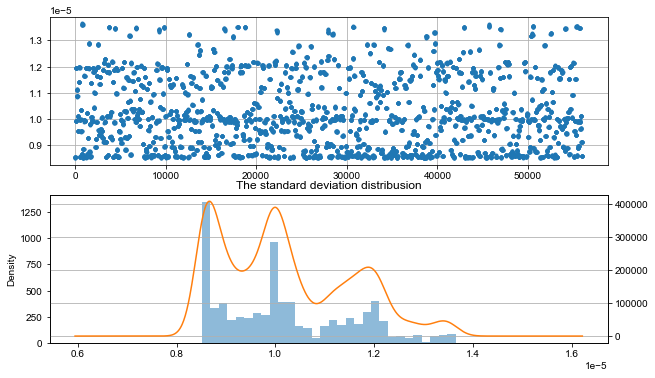

In [133]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(0.01) # diffusion is sqrt(h)*theta(x0) 

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)
#ax1.scatter(s.index, s.values)
ax1.plot(s.index, s.values,'.')
plt.grid()
 
ax2 = fig.add_subplot(2,1,2) 
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.title('The standard deviation distribusion')
plt.grid()

In [215]:
best_selfDyn = selfDyn_over_time[29]
best_selfDyn = pd.DataFrame(best_selfDyn)
TimeSeries = best_selfDyn.iloc[:,0:dim].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [216]:
best_selfDyn

,Vi,dxi,dyi,s1,s2
0,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
1,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
2,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
3,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
4,0.000001,2.240453e-04,-0.001203,-0.000059,-0.000116
...,...,...,...,...,...
55995,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115
55996,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115
55997,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115
55998,0.000002,-5.915492e-07,-0.001258,-0.000059,-0.000115


In [217]:
self_true = (best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
#self_true = best_selfDyn['dxi']*best_selfDyn['Vi']
self_true_1 = np.sqrt(best_selfDyn['Vi'])*best_selfDyn['dxi']
self_true_2 = best_selfDyn['dxi']

In [218]:
maxy = np.max(best_selfDyn['s1'].values)
miny = np.min(best_selfDyn['s1'].values)
maxx = np.max(self_true)
minx = np.min(self_true)
self_true = (maxy-miny)*(self_true-minx)/(maxx-minx) + miny

In [219]:
(maxy-miny)/(maxx-minx)

1.7975674649230606

In [220]:
minx

8.477218784719298e-07

In [221]:
maxx-minx

1.6579251109760662e-06

In [222]:
miny

-5.9990212e-05

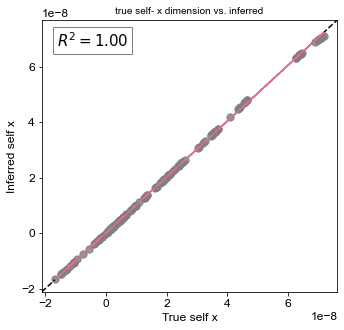

In [240]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#self_true = 0.4*(-np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2))
ri = np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
sx = best_selfDyn['s1'].values*best_selfDyn['dxi']
sx_true = self_true*best_selfDyn['dxi']
sx = sx[0:1000]
sx_true = sx_true[0:1000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_self.pdf')

In [143]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

self_true_1 = np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)#*best_selfDyn['dxi']
self_true_2 = best_selfDyn['dxi']
Xfind = self_true_1.values.reshape(-1,1)#pd.concat([self_true_1,self_true_2],axis=1)
yfind = best_selfDyn['s1'].values
model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_

In [144]:
a

array([-0.00078592], dtype=float32)

In [145]:
model_linear.score(Xfind,yfind)

0.006713225187827465